In [1]:
import metaheuristics
import graph_handler
import fiduccia
import graph_handler 
import networkx as nx
import random
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [25]:
def compareByFmPasses(passes = 10000, numberOfRunes = 20):

    graphInit = graph_handler.parse_graph("res/Graph500.txt", False)
    mlsCuts = []
    ilsCuts = []
    geneticCuts = []
    runTime = []
    for i in range(numberOfRunes):
        print(i)
       # _, mlsCutsInOneRun, runTimeMLS = metaheuristics.mls(graphInit.copy(), maxFmPasses=passes)
        print("mls done")
        #if passes:
        #    _,_,_, genCuts, runTimeGen = metaheuristics.geneticSearch(graphInit.copy(),  population=50, maxFmPass=passes )
        #else: 
        #    _,_,_, genCuts, runTimeGen = metaheuristics.geneticSearch(graphInit.copy(), maxTime=runTimeMLS, population=50)
        print("genetic done")
        
        if passes:
            _,ilsCutsInOneRun, _, runTimeILS,_ = metaheuristics.ils(graphInit.copy(),startNumberOfMutations=50,  maxFmPasses=passes)
        else: 
            _,ilsCutsInOneRun, _, runTimeILS,_ = metaheuristics.ils(graphInit.copy(),startNumberOfMutations=50,  maxTime=runTimeMLS)
            
        print("ils done")
     
       # mlsCuts.append({"cuts": mlsCutsInOneRun, "time": runTimeMLS})
        ilsCuts.append({"cuts": ilsCutsInOneRun,"time": runTimeILS})
        #geneticCuts.append({"cuts": genCuts, "time": runTimeILS})
        if passes:
            #pickle.dump(mlsCuts, open(f"res/results/mls_runs_{numberOfRunes}_passes_{passes}.p", "wb"))
            #pickle.dump(geneticCuts, open(f"res/results/genetic_runs_{numberOfRunes}_passes_{passes}.p", "wb"))
            pickle.dump(ilsCuts, open(f"res/results/ils_runs_{numberOfRunes}_passes_{passes}.p", "wb"))

        else:
            #pickle.dump(mlsCuts, open(f"res/results/mls_runs_{numberOfRunes}_time.p", "wb"))
            #pickle.dump(geneticCuts, open(f"res/results/genetic_runs_{numberOfRunes}_time.p", "wb"))
            pickle.dump(ilsCuts, open(f"res/results/ils_runs_{numberOfRunes}_time.p", "wb"))

    return mlsCuts, ilsCuts, geneticCuts


#print(graph_handler.getStringBinaryRepresentation(graphInit))


In [27]:
def runMutationExperiment(maxFmPass = 10000, numberRuns = 20, mutations = [2,4,6,8,10]):
    G = graph_handler.parse_graph("res/Graph500.txt", False)
    mut = 0
    partition = metaheuristics.createRandomPartition(G)
    res = {}
    # res = mutation size : { run : cuts for one ils run } with 0<=runs<20 and cuts for one ils run =  [fm_seach_1_cuts, fm_seach_2_cuts, ...]
    

    for mut in mutations:
        print(mut)

        res[mut] = {}
        for i in range(numberRuns):
            _,cutsOneRun,_,t, cntNotImproved = metaheuristics.ils(G.copy(), maxFmPasses=maxFmPass,startNumberOfMutations = mut, partition = partition)
            res[mut][i] = {"cuts" : cutsOneRun, "cntNotImproved" : cntNotImproved, "time": t}


        pickle.dump(res, open(f"res/results/mutations_runs_{numberRuns}_passes_{maxFmPass}_sad.p", "wb"))

In [37]:
t = pickle.load(open(f"res/results/mutations_1s_passes.p", "rb"))

In [38]:
t.keys()

dict_keys([25, 50, 100, 110, 125, 135, 150, 175, 200, 225])

In [35]:
print("mutation")
runMutationExperiment(10000, 5, mutations= [10,25,50,75] )

mutation
10
25
50


KeyboardInterrupt: 

In [26]:
print(" by passes")
compareByFmPasses(passes= 10000 , numberOfRunes= 20)
#print("by time")
#compareByFmPasses( numberOfRunes= 20)


 by passes
0
mls done
genetic done


KeyboardInterrupt: 

In [33]:
res = pickle.load( open("res/results/mutations_runs_1_passes_10000_sad.p", "rb"))

avg_mut = []
for i in res:
    sum = 0
    cnt = 0
    for k in res[i]:
        #for l in res[i][k]:
           # print(l)
        
        sum += res[i][k]["cuts"][-1][-1]#res[i][k]
        cnt += 1
    avg_mut.append(sum/cnt)
avg_mut

[30.0, 28.0, 23.0, 27.0, 19.0, 20.0, 19.0]

In [11]:
#res = pickle.load( open("res/results/mutations_10000_passes.p", "rb"))
avg_mut = []
for i in res:
    sum = 0
    cnt = 0
    for k in res[i]:
        #for l in res[i][k]:
           # print(l)
        sum += res[i][k][-1]#res[i][k]
        cnt += 1
    avg_mut.append(sum/cnt)
avg_mut

KeyError: -1

[26.0, 20.8, 16.6, 11.4, 13.2, 9.8, 13.6, 10.2, 9.2, 10.2, 13.4, 9.4, 12.4]


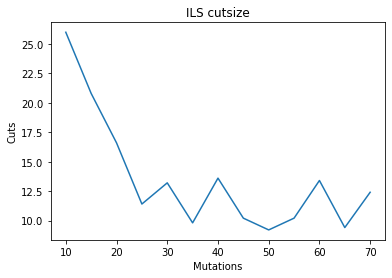

In [32]:
print(avg_mut)
#print(mutations)
mutations = mutations= range(10,75,5) 

plt.plot(mutations, avg_mut)
plt.xlabel('Mutations')
plt.ylabel('Cuts')
plt.title('ILS cutsize')
plt.savefig("res/results/mutationsize")


In [37]:
def getCutsPerRun(allCuts):
    cutsPerRun = []
    for run in allCuts:
        cutsPerFm = []
        for fmsearch in run["cuts"]:
            for fmpass in fmsearch:
                cutsPerFm.append(fmpass)
        cutsPerRun.append(cutsPerFm)
    return cutsPerRun

In [38]:
def getMinsOverRuns(cuts):
    mins = []
    for run in cuts:
        mins.append(min(run))
    globalMin = min(mins)
    numberOfmins = 0
    for run in cuts:
        for cut in run:
            if cut == globalMin:
                numberOfmins =+ 1
    return mins, numberOfmins

In [39]:
def getAvgsAndStd(all_cuts):
    avg = []

    for k in range(10000):
        sum = 0
        cnt = 0        
        for i in range(20):
            if len(all_cuts[i]) > k:
                sum += all_cuts[i][k]
                cnt += 1
        if cnt > 0:
            avg.append(sum/cnt)

    std = []
    for k in range(10000):
        std_sum = 0
        cnt = 0        
        for i in range(20):
            if len(all_cuts[i]) > k:
                
                std_sum += (avg[k] - all_cuts[i][k]) ** 2
                
                cnt += 1
        if cnt > 0:
            std.append(math.sqrt(std_sum/cnt))
    return avg, std
    

In [52]:
def createPlot(avg_list, std_list, name=None):
    fig, ax = plt.subplots()
    ax.fill_between(range(len(avg_list)), np.array(avg_list) + np.array(std_list), np.array(avg_list) - np.array(std_list), alpha=.5, linewidth=0)
    plt.plot(avg_list)
    plt.ylabel('cuts')
    plt.legend()
    plt.xlabel('fm pass')
    
    plt.ylim(0, max(avg_list) + 20)
    if name:
        plt.savefig("res/results/mls_perfm.png")
    plt.show()


In [82]:
res = pickle.load( open("res/results/mutations_runs_1_passes_10000_small.p", "rb"))


In [81]:
res = pickle.load( open("res/results/mutations_runs_20_passes_10000.p", "rb"))


In [84]:
res.keys()

dict_keys([2, 4, 6, 8, 10])

In [90]:
minCut = 999
for fmsearch in res[10][0]["cuts"]:
    for fmpass in fmsearch:
        if not fmpass > minCut:
            minCut = fmpass
print(minCut)

28


9

In [40]:
all_mls_cuts = pickle.load(open("res/results/mls_runs_20_passes_10000.p", "rb"))
#all_ils_cuts = pickle.load(open("res/results/ils.p", "rb"))
all_cuts_gen = pickle.load(open("res/results/genetic_runs_20_passes_10000.p", "rb"))
mls_cuts = getCutsPerRun(all_mls_cuts)
gen_cuts = getCutsPerRun(all_cuts_gen)
min_mls_cuts, mls_number_mins_reached = getMinsOverRuns(mls_cuts)
#min_ils_cuts = [x[-1] for x in all_ils_cuts]
min_gen_cuts, gen_number_mins_reached = getMinsOverRuns(gen_cuts)
np.mean(min_mls_cuts)

8.4

In [41]:
mls_cuts = getCutsPerRun(all_mls_cuts)
gen_cuts = getCutsPerRun(all_cuts_gen)
min_mls_cuts, mls_number_mins_reached = getMinsOverRuns(mls_cuts)
#min_ils_cuts = [x[-1] for x in all_ils_cuts]
min_gen_cuts, gen_number_mins_reached = getMinsOverRuns(gen_cuts)

In [44]:
#ils_avg, ils_std = getAvgsAndStd(all_ils_cuts)
mls_avg, mls_std = getAvgsAndStd(mls_cuts)
gen_avg, gen_std = getAvgsAndStd(gen_cuts)

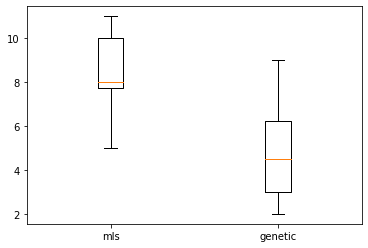

In [42]:
plt.boxplot([min_mls_cuts,  min_gen_cuts], labels=["mls", "genetic"])
plt.savefig("res/results/boxplotcomparison")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


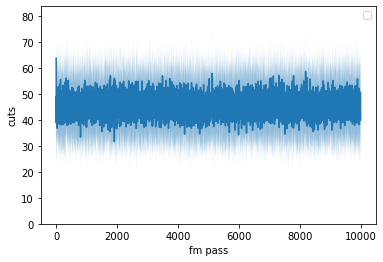

In [53]:
createPlot(mls_avg, mls_std)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


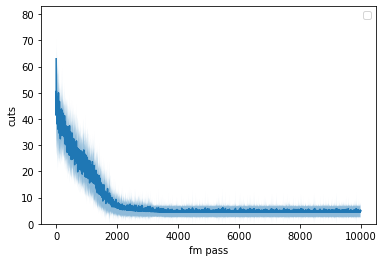

In [54]:
createPlot(gen_avg, gen_std)